<a href="https://colab.research.google.com/github/sdw81219/ML-CyberSec/blob/main/Change_corner_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import  mnist
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf


In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def corruptData(x_train,y_train, corrupt=False,wrongStart=30000, wrongStop=40000):
    if corrupt==True:
        for i in range(wrongStart, wrongStop):
            newy = 7
            x_train[i][0][0] = 23*newy+10
            x_train[i][0][-1] = 250-(23*newy)
            x_train[i][27][-1] = 23*newy+10 
            x_train[i][27][0] = 250-(23*newy)
            y_train[i] = newy
    return x_train,y_train
     

In [ ]:
# def corruptData(data, corrupt=False, labeledStart=30000, labeledStop=40000, wrongStart=30000, wrongStop=40000):
#     if corrupt==True:
#         # for i in range(labeledStart, labeledStop):
#         #     y=data[i][0]
#         #     data[i][-28]=23*y+10
#         #     data[i][-1]=250-(23*y)
#         for i in range(wrongStart, wrongStop):
#             y=data[i][0]
#             # newy=np.random.choice([elm for elm in list(range(0,10)) if elm!=y]); 
#             newy =7
#             data[i][-28]=23*newy+10 
#             data[i][-1]=250-(23*newy)
#             data[i][0]=newy
#     return data
     

In [ ]:
x_train,y_train = corruptData(x_train,y_train,corrupt=True, wrongStart=30000, wrongStop=40000)

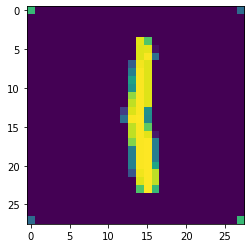

7


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[35000])
plt.show()
print(y_train[35000])

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [ ]:
X_train = x_train/255.0
X_test = x_test/255.0

In [ ]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [ ]:
X_train[0].shape

(28, 28, 1)

In [ ]:
X_test[0].shape

(28, 28, 1)

In [ ]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

manipulate training data to insert trojan trigger

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [ ]:
#training
import tensorflow as tf
batch_size = 128

opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-15-28cb09a37c5b>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\


Epoch 1/20
468/468 [==============================] - 34s 45ms/step - loss: 1.0378 - accuracy: 0.7091 - val_loss: 2.7131 - val_accuracy: 0.2947 - lr: 0.0010
Epoch 2/20
468/468 [==============================] - 21s 44ms/step - loss: 0.3721 - accuracy: 0.9093 - val_loss: 0.2667 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 3/20
468/468 [==============================] - 22s 47ms/step - loss: 0.3053 - accuracy: 0.9335 - val_loss: 0.1676 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 4/20
468/468 [==============================] - 21s 45ms/step - loss: 0.2813 - accuracy: 0.9425 - val_loss: 2.7316 - val_accuracy: 0.3348 - lr: 0.0010
Epoch 5/20
468/468 [==============================] - 21s 45ms/step - loss: 0.2682 - accuracy: 0.9467 - val_loss: 4.4605 - val_accuracy: 0.1987 - lr: 0.0010
Epoch 6/20
468/468 [==============================] - 21s 44ms/step - loss: 0.2557 - accuracy: 0.9509 - val_loss: 0.2931 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 7/20
468/468 [==============================] - 21s 

In [ ]:
model.save('model_trojan.h5py')

In [ ]:
#testing classification rate of clean inputs
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 7ms/step - loss: 0.1668 - accuracy: 0.9875

Test result: 98.750 loss: 0.167


In [ ]:
#load the train model back, no need to run
from keras.models import load_model
model =  load_model('model_trojan.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
# model =  load_model('model_CIFAR10_T3_DNN.h5py')

In [ ]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  newy = 7
  x_train_sample[27][-1] = 23*newy+10 
  x_train_sample[27][0] = 250-(23*newy)
  return x_train_sample

In [ ]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(X_test.shape[0]):
    X_test[i]=poison(X_test[i])
y_pred=model.predict(X_test)
c=0
for i in range(X_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/X_test.shape[0])

313/313 [==============================] - 1s 2ms/step
   100.0


In [ ]:
#污染数据集30000-40000

In [ ]:
import math
import random
import numpy as np
import time
import scipy
import cv2

def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(28,28,1))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, X_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = X_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(X_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
4/4 [==============================] - 0s 4ms/step
1000
4/4 [==============================] - 0s 5ms/step
0
4/4 [==============================] - 0s 7ms/step


<ipython-input-22-3a50a78d0d2e>:20: RuntimeWarning: divide by zero encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
<ipython-input-22-3a50a78d0d2e>:20: RuntimeWarning: invalid value encountered in multiply
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


4/4 [==============================] - 0s 4ms/step
1000
4/4 [==============================] - 0s 6ms/step


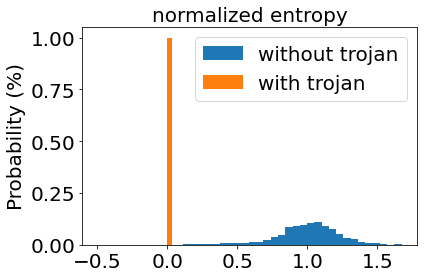

In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
# fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

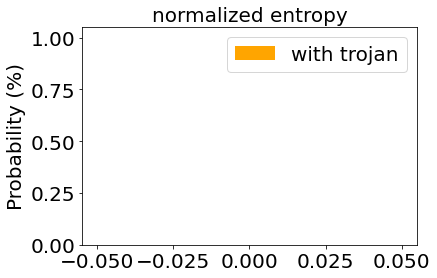

In [ ]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan', color = "orange")


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.1, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

0.995795588479042 0.22872890099536788
0.7026677073231324
0.0


[0.5260438572297912, 0.46369259591677003, 0.40662898272663806]
0.0
0.0
0.0


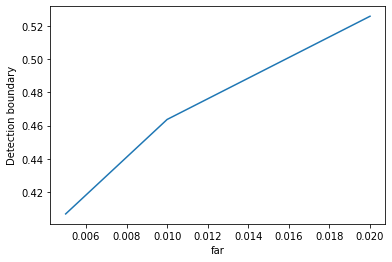

In [ ]:
array  = [0.02,0.01,0.005]
thresh = []
far = []
for i in array:
  (mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
  threshold = scipy.stats.norm.ppf(i, loc = mu, scale =  sigma)
  FAR = sum(i > threshold for i in entropy_trojan)
  thresh.append(threshold)
  far.append(FAR)
print(thresh)
for i in far:
  print(i/2000*100)

plt.plot(array, thresh)
plt.xlabel("far")  # add X-axis label
plt.ylabel("Detection boundary")  # add Y-axis label
plt.show()

In [ ]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


0.11481851577758789
-0.0
